# Neural Network from Scratch in Python

In [65]:
from dataclasses import dataclass
from abc import ABC, abstractmethod
import numpy as np
from typing import List
import matplotlib.pyplot as plt

## 1 Layer, 1 Neuron Neural Network, OR logic gate
What goes on inside a perceptron?

$z = \mathbf{w} \cdot \mathbf{x} + b = w_0x_0 + w_1x_1 + b$

We introduce non-linearity to the system using the sigmoid function i.e.
$a = \sigma(z) = \frac{1}{1+e^{-z}}$

### Backpropagation
The problem regards how we actually update the weights of each neuron in the system. A common method utilises what is called the _gradient descent_ algorithm.
This involves updating the weights of each neuron, every epoch we train the model. A hyperparameter $\eta$ is introduced which is commonly called the _learning rate_ (LR) or occassionally _mixing parameter_.

$
\begin{equation}
\mathbf{w}' = \mathbf{w} - \eta \frac{\partial E}{\partial \mathbf{w}}
\end{equation}
$

We use the chain rule to solve $\frac{\partial E}{\partial \mathbf{w}}$ i.e.
$\begin{equation}
\frac{\partial E}{\partial \mathbf{w}} = \frac{\partial E}{\partial a} \frac{\partial a}{\partial z} \frac{\partial z}{\partial \mathbf{w}}
\end{equation}$

Solving each term (assuming the Error Function is MSE here and activation function is sigmoid in this case):
$\begin{equation}
\frac{\partial E}{\partial a} = \frac{\partial}{\partial a}\frac{1}{2} (y - a)^2 = a - y
\end{equation}$

$\begin{equation}
\frac{\partial a}{\partial z} = \frac{\partial}{\partial z}\sigma(z) = \sigma(z)(1 - \sigma(z))
\end{equation}$

$\begin{equation}
\frac{\partial z}{\partial \mathbf{w}} = \frac{\partial}{\partial \mathbf{w}} \mathbf{w} \cdot \mathbf{x} + b = \mathbf{x}
\end{equation}$

which finally gives us

$\begin{equation}
\frac{\partial E}{\partial \mathbf{w}} = (a - y) \times \sigma(z)(1 - \sigma(z)) \times \mathbf{x}
\end{equation}$

and finally what about the bias?

$\begin{equation}
\frac{\partial E}{\partial b} = \frac{\partial E}{\partial a} \frac{\partial a}{\partial z} \frac{\partial z}{\partial b}
\end{equation}$

We know most of these terms except the last

$\begin{equation}
\frac{\partial z}{\partial b} = \frac{\partial}{\partial b} \mathbf{w} \cdot \mathbf{x} + b = 1
\end{equation}$

and so, finally

$\begin{equation}
\frac{\partial E}{\partial b} = (a - y) \times \sigma(z)(1 - \sigma(z))
\end{equation}$

In [66]:
class ActivationFunction(ABC):
    @abstractmethod
    def function(self):
        pass

    @abstractmethod
    def derivative(self):
        pass

class ErrorFunction(ABC):
    @abstractmethod
    def function(self):
        pass

    def derivative(self):
        pass

In [190]:

@dataclass
class Sigmoid(ActivationFunction):
    name: str = 'sigmoid'

    def function(self, x):
        return 1/(1 + np.exp(-x))
    
    def derivative(self, x):
        return self.function(x)*(1-self.function(x))
    
@dataclass 
class MeanSquaredError(ErrorFunction):
    name: str = 'MSE'

    def function(self, a, y):
        return 0.5*(y - a)**2
    
    def derivative(self, a, y):
        return (a - y)

@dataclass
class Neuron():
    input_shape: int
    activation_function: ActivationFunction
    weights: np.ndarray[np.float64] = None
    bias: float = np.random.rand()
    del_w0: float = 0
    del_b0: float = 0

    def __post_init__(self):
        """Initialise the weights. We do this post_initialisation because we depend
        on the input shape.
        """
        self.weights = np.random.rand(self.input_shape)

    def forward(self, x: np.ndarray) -> float:
        self.inputs = x
        weighted_sum = np.dot(self.weights, x) + self.bias
        return self.activation_function.function(weighted_sum)
    
    def backward(self, error_derivative: np.ndarray):
        delta = error_derivative * self.activation_function.derivative(
            np.dot(self.weights, self.inputs) + self.bias
            )
        #self.del_w0 += np.dot(delta, np.transpose(self.inputs))
        self.del_w0 += np.squeeze(np.transpose(np.outer(delta, np.transpose(self.inputs))))
        self.del_b0 += delta
        #self.weights -= (lr/4) * self.del_w0
        #self.bias -= (lr/4) * self.del_b0

        return delta
    
    def update_weights(self, lr=0.05):
        self.weights -= (lr/4) * self.del_w0
        self.bias -= (lr/4) * self.del_b0
        self.del_w0 = 0
        self.del_b0 = 0


In [191]:
X = [[0, 0], [0, 1], [1, 0], [1, 1]]
Y = [0, 1, 1, 1]

In [192]:
n1 = Neuron(2, Sigmoid())
for x, y in zip(X, Y):
    x = np.array(x)
    y = np.array(y)

    a = n1.forward(x)
    E = 0.5*(y - a)**2
    E_prime = (a - y)

print(E_prime)

-0.3403103524174864


In [154]:
delta = E_prime * n1.activation_function.derivative(np.dot(n1.weights, n1.inputs) + n1.bias)
print(delta)

np.squeeze(np.transpose(np.outer(delta, np.transpose(n1.inputs))))

-0.02864652196225718


array([-0.02864652, -0.02864652])

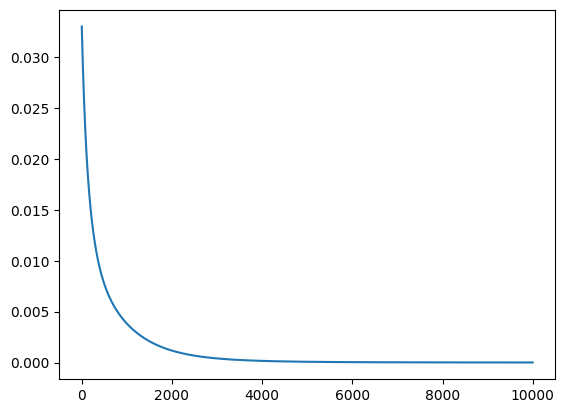

In [193]:
n1 = Neuron(2, Sigmoid())
all_E = []
for i in range(10000):
    for x, y in zip(X, Y):
        x = np.array(x)
        y = np.array(y)

        a = n1.forward(x)
        E = 0.5*(y - a)**2
        E_prime = (a - y)
        delta = n1.backward(E_prime)

        n1.update_weights()
    all_E += [E]

plt.figure()
plt.plot(all_E)
plt.show()

In [159]:
delta

-1.1260117987957873e-05

In [240]:
n0 = Neuron(2, Sigmoid())
n1 = Neuron(1, Sigmoid())
all_E = []
for i in range(100000):
    E = 0
    for x, y in zip(X, Y):
        x = np.array(x)
        y = np.array(y)

        a0 = n0.forward(x)
        a1 = n1.forward(a0)
        E += 0.5*(y - a1)**2
        E_prime = (a1 - y)
        d1 = n1.backward(E_prime)[0]
        d0 = n0.backward(np.dot(n1.weights[0], d1))

    n1.update_weights()
    n0.update_weights()
    all_E += [E]

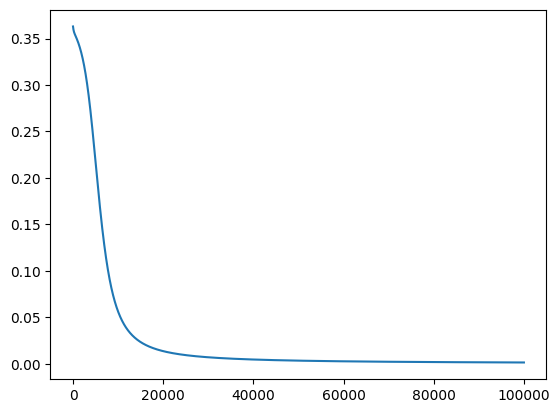

In [241]:
plt.figure()
plt.plot(all_E)
plt.show()

In [243]:
x = np.array([1, 1])

a0 = n0.forward(x)
a1 = n1.forward(a0)
print(a1)

[0.98940585]


In [223]:
n0 = Neuron(2, Sigmoid())
n1 = Neuron(1, Sigmoid())
x = np.array([1, 1])
y = np.array([1])

a0 = n0.forward(x)
a1 = n1.forward(a0)
E = 0.5*(y - a1)**2
E_prime = (a1 - y)
d1 = n1.backward(E_prime)
d0 = n0.backward(np.dot(n1.weights, d1))


In [224]:
a

0.996713174900421

In [180]:
x = np.array([1, 1])

a0 = n0.forward(x)
a1 = n1.forward(a0)

print(a1)

[0.0039805]


In [174]:
E

5.649046930534311e-06

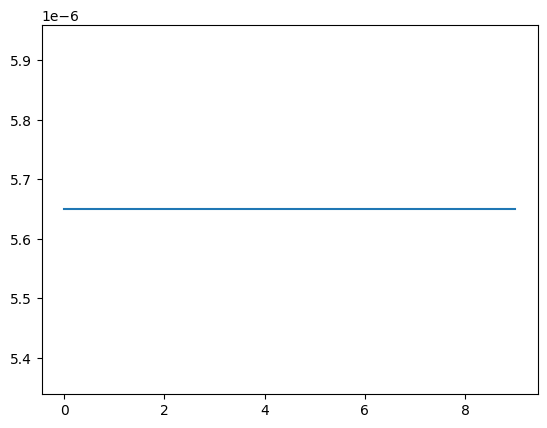

In [175]:
plt.figure()
plt.plot(all_E)
plt.show()

In [105]:
n0.inputs, n1.inputs

(array([1, 1]), 0.9210728007003894)

In [ ]:
@dataclass
class Layer():
    num_neurons: int
    input_tensor: np.ndarray
    activation: ActivationFunction
    neurons: List[Neuron] = None

    def __post_init__(self):
        self.neurons = [Neuron(np.shape(self.input_tensor), self.activation) for _ in range(self.num_neurons)]

    def forward(self, x):
        raise NotImplementedError
    
    def backward(self, x, y, lr=0.05):
        raise NotImplementedError

In [58]:
x = np.array([0, 0])
a0 = n0.forward(x)
a1 = n1.forward(a0)
print(a1)

[1.00686481e-11]


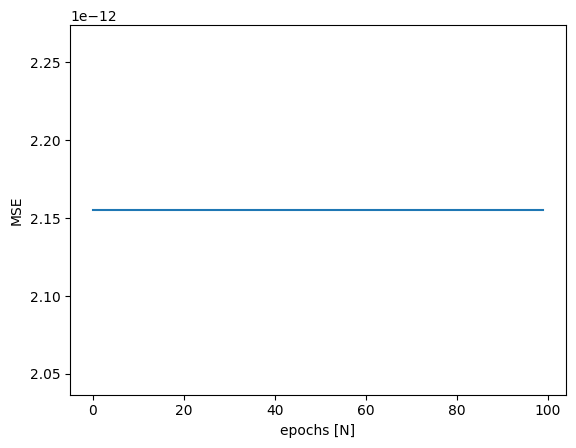

In [59]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(len(all_E)), all_E)
plt.xlabel('epochs [N]')
plt.ylabel('MSE')
plt.show()

In [ ]:
n00 = Neuron(2, Sigmoid())
n01 = Neuron(2, Sigmoid())
n10 = Neuron(2, Sigmoid())

In [ ]:
layer0 = [n00, n01]
layer1 = [n10]

network = [layer0, layer1]

In [ ]:
x

In [ ]:
a0 = [layer0[0].forward(x), layer0[1].forward(x)]
a1 = [layer1[0].forward(a0)]

print(a0)
print(a1)